In [1]:
import re
import pandas as pd
import numpy as np
import os
from copy import copy
from sklearn.model_selection import train_test_split
import nltk
from textaugment import Wordnet, EDA
import nlpaug.augmenter.word as naw

In [2]:
from tqdm import tqdm
tqdm.pandas()

import sys
sys.path.append(f'../../')

from src.features.parallelize import apply_parallel 

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def concat_and_explode_syn(df):
    df['term'] = df.apply(
        #lambda row: [row['STR']] + [i for i in list(set(eval(row['SNMS'])))[:3] if i.lower() != row['STR'].lower()], axis=1)
        lambda row: [row['STR']] + [i for i in list(set(eval(row['SNMS'])))[:3] if i.lower() != row['STR'].lower()], axis=1)
    return df

def concat_and_explode(df):
    df['term'] = df.apply(
        lambda row: [row['STR']], axis=1)
    return df

def clear_spec_symb(df):
    ps = [r'\(.*?\)', 'NOS', r'\[.*?\]', ':', '\,']
    for pattern in ps:
        df['term'] = df['term'].apply(
            lambda row: re.sub(pattern, '', row))

    df['term'] = df['term'].apply(
            lambda row: ' '.join(set(row.lower().split(' '))))
    df = df[df['term'] != ''].drop_duplicates(subset=['term', 'code'])
    return df

In [5]:
mdr_codes_to_exp = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
mdr_codes_to_exp = mdr_codes_to_exp[['STR', 'SNMS', 'CODE']]
mdr_codes_to_exp = apply_parallel(mdr_codes_to_exp, concat_and_explode)
mdr_codes_to_exp = mdr_codes_to_exp.explode('term')[['term', 'CODE']].rename(columns={'CODE': 'code'})
mdr_codes_to_exp

,term,code
0,Ventilation pneumonitis,10000001
1,11-beta-hydroxylase deficiency,10000002
2,11-oxysteroid activity incr,10000003
3,11-oxysteroid activity increased,10000004
4,17 ketosteroids urine,10000005
...,...,...
84208,Infective pneumonia (SMQ),20000231
84209,Dehydration (SMQ),20000232
84210,['Hypokalaemia (SMQ)' 'Hypokalemia (SMQ)'],20000233
84211,Sepsis (SMQ),20000234


In [6]:
mdr_codes_to_exp = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
mdr_codes_to_exp = mdr_codes_to_exp[['STR', 'SNMS', 'CODE']]
mdr_codes_to_exp = apply_parallel(mdr_codes_to_exp, concat_and_explode_syn)
mdr_codes_to_exp = mdr_codes_to_exp.explode('term')[['term', 'CODE']].rename(columns={'CODE': 'code'})
mdr_codes_to_exp

,term,code
0,Ventilation pneumonitis,10000001
0,Humidifier lung (disorder),10000001
0,Air-conditioner and humidifier lung (disorder),10000001
0,Air-conditioner and humidifier lung,10000001
1,11-beta-hydroxylase deficiency,10000002
...,...,...
84208,Infective pneumonia (SMQ),20000231
84209,Dehydration (SMQ),20000232
84210,['Hypokalaemia (SMQ)' 'Hypokalemia (SMQ)'],20000233
84211,Sepsis (SMQ),20000234


In [7]:
import re

def clearing(x):
    x = re.sub('\[.*\]', '', x)
    x = re.sub('\(.*\)', '', x)
    x = re.sub('-.*-', '', x)
    x = x.replace('%', 'percent')
    x = x.replace(':', '')
    for abb in ['NOS', 'HOH', 'URS', 'AAOOR']:
        x = x.replace(abb, '')
    x = x.strip()
    return x

mdr_codes_to_exp['term'] = mdr_codes_to_exp['term'].apply(lambda x: clearing(x))
mdr_codes_to_exp = mdr_codes_to_exp.drop_duplicates()
mdr_codes_to_exp = mdr_codes_to_exp[mdr_codes_to_exp['term'] != '']
mdr_codes_to_exp

,term,code
0,Ventilation pneumonitis,10000001
0,Humidifier lung,10000001
0,Air-conditioner and humidifier lung,10000001
1,11hydroxylase deficiency,10000002
1,Adrenogenital disorder due to 11 beta-hydroxyl...,10000002
...,...,...
84207,['Non-haematological tumours of unspecified ma...,20000230
84208,Infective pneumonia,20000231
84209,Dehydration,20000232
84211,Sepsis,20000234


In [8]:
all_used_codes_cadec.shape, all_used_codes_psytar.shape, all_used_codes_smm4h21.shape, all_used_codes_smm4h17.shape

NameError: name 'all_used_codes_cadec' is not defined

In [ ]:
used_codes = np.concatenate([
    all_used_codes_cadec, all_used_codes_psytar, all_used_codes_smm4h21, all_used_codes_smm4h17
]) #.shape
used_codes.shape

In [ ]:
np.unique(used_codes).shape

In [ ]:
mdr_codes_to_exp = mdr_codes_to_exp[mdr_codes_to_exp['code'].isin(np.unique(used_codes))]
mdr_codes_to_exp

In [ ]:
mdr_codes_to_exp = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv').rename(columns={'CODE': 'code'})
mdr_codes_to_exp.to_csv('../../data/interim/used_codes_big.csv')

In [ ]:
mdr_codes_to_exp = mdr_codes_to_exp[mdr_codes_to_exp['code'].isin(np.unique(used_codes))]
mdr_codes_to_exp.to_csv('../../data/interim/used_codes.csv')

In [ ]:
mdr_codes_to_exp[mdr_codes_to_exp['code'].isin(np.unique(used_codes))]


# PIPE

In [10]:
aug_wdnt = naw.SynonymAug(aug_src='wordnet')
aug_ppdb = naw.SynonymAug(aug_src='ppdb', model_path='../../data/external/embeddings/ppdb-2.0-tldr')

In [ ]:
N_rareness = 6

def get_ready_data(df_train, df_val, name, use_clear=True):
    
    needed_columns = ['term', 'sent', 'text', 'code', 'STR', 'SNMS']
    needed_columns = [i for i in needed_columns if i in df_train.columns]
    print(needed_columns)
    
    dict_concepts = mdr_cod_to_norm[['STR', 'CODE']].rename(columns={'CODE':'code', 'STR':'term'})
    if use_clear: 
        df_train = clear_spec_symb(df_train)
    df_train[needed_columns].to_csv(f'../../data/interim/{name}/train_pure.csv', index=False)
    df_val[needed_columns].to_csv(f'../../data/interim/{name}/test.csv', index=False)
    print(f"train: {df_train.shape} / test: {df_val.shape}")
    
    df_train_aug = copy(df_train)
    t = Wordnet()
    df_train_aug['term'] = df_train_aug['term'].progress_apply(lambda mention: t.augment(mention))
    df_train_aug = pd.concat([df_train_aug, df_train])[needed_columns]
    df_train_aug.to_csv(f'../../data/interim/{name}/train_aug.csv', index=False)
    print(f"train augmented textaugment wdnt: {df_train_aug.shape}")
    
    df_train_aug_wdnt = copy(df_train)
    df_train_aug_wdnt['term'] = df_train_aug_wdnt['term'].progress_apply(lambda mention: aug_wdnt.augment(mention))
    df_train_aug_wdnt = pd.concat([df_train_aug_wdnt, df_train])[needed_columns]
    df_train_aug_wdnt.to_csv(f'../../data/interim/{name}/train_aug_wdnt.csv', index=False)
    print(f"train augmented nlpaug wdnt: {df_train_aug_wdnt.shape}")
          
    df_train_aug_ppdb = copy(df_train)
    df_train_aug_ppdb['term'] = df_train_aug_ppdb['term'].progress_apply(lambda mention: aug_ppdb.augment(mention))
    df_train_aug_ppdb = pd.concat([df_train_aug_ppdb, df_train])[needed_columns]
    df_train_aug_ppdb.to_csv(f'../../data/interim/{name}/train_aug_ppdb.csv', index=False)
    print(f"train augmented nlpaug ppdb: {df_train_aug_ppdb.shape}")
        
    for n_runs in [2, 3]:
        df_train_aug = copy(df_train)
        t = Wordnet(v=True ,n=True, runs=n_runs)
        
        indices_inferior = df_train_aug['code'].value_counts()[df_train_aug['code'].value_counts() < N_rareness].index
        df_train_aug = df_train_aug[df_train_aug['code'].isin(indices_inferior)]
        
        multiple_times_augmented = []
        for i in range(5):
            df_train_aug['term'] = df_train_aug['term'].progress_apply(lambda mention: t.augment(mention))
            multiple_times_augmented.append(df_train_aug)
            
        df_train_aug = pd.concat(multiple_times_augmented)
        df_train_aug = pd.concat([df_train_aug, df_train])[needed_columns]
        df_train_aug = df_train_aug.drop_duplicates(subset=['term', 'code'], keep='last')
        df_train_aug.to_csv(f'../../data/interim/{name}/train_textaug_wdnt_{n_runs}_repl.csv', index=False)
        print(f"train augmented textaugment wdnt repl {n_runs}: {df_train_aug.shape}")  
        
    df_train_aug = copy(df_train)
    t = EDA() 
    indices_inferior = df_train_aug['code'].value_counts()[df_train_aug['code'].value_counts() < N_rareness].index
    df_train_aug = df_train_aug[df_train_aug['code'].isin(indices_inferior)]
    def augment_insertion(mention):
        try:
            return t.random_insertion(mention)
        except Exception as e:
            return mention
    df_train_aug['term'] = df_train_aug['term'].progress_apply(augment_insertion)
    df_train_aug = pd.concat([df_train_aug, df_train])[needed_columns]
    df_train_aug = df_train_aug.drop_duplicates(subset=['term', 'code'], keep='last')
    df_train_aug.to_csv(f'../../data/interim/{name}/train_textaug_wdnt_insrt.csv', index=False)
    print(f"train augmented textaugment wdnt insrt: {df_train_aug.shape}")  
    

    df_train_aug = copy(df_train)
    t = EDA() 
    indices_inferior = df_train_aug['code'].value_counts()[df_train_aug['code'].value_counts() < N_rareness].index
    df_train_aug = df_train_aug[df_train_aug['code'].isin(indices_inferior)]
    def augment_insertion(mention):
        try:
            return t.random_insertion(mention)
        except Exception as e:
            return mention
    df_train_aug['term'] = df_train_aug['term'].progress_apply(augment_insertion)
    df_train_aug = pd.concat([df_train_aug, df_train])
    df_train_aug['SNMS'] = df_train_aug['SNMS'].apply(lambda row: list(set(eval(row))))
    df_train_aug['term'] = df_train_aug.progress_apply(
        lambda x: ' '.join(list(set([x['STR']] + x['SNMS']))), axis=1)
    df_train_aug = pd.concat([df_train, df_train_aug])[needed_columns]
    if use_clear: 
        df_train_aug = clear_spec_symb(df_train_aug)
    df_train_aug = df_train_aug[needed_columns].drop_duplicates(subset=['term', 'code'], keep='last')
    df_train_aug.to_csv(f'../../data/interim/{name}/train_textaug_wdnt_insrt_retro.csv', index=False)
    print(f"train augmented textaugment wdnt insrt CONCEPT_RETRO: {df_train_aug.shape}")  
    
    df_train_concept = copy(df_train)
    df_train_concept['term'] = df_train_concept.progress_apply(lambda row: [row['term'], row['STR']], axis=1)
    df_train_concept = df_train_concept[needed_columns].explode('term')
    if use_clear: 
        df_train_concept = clear_spec_symb(df_train_concept)
    df_train_concept.to_csv(f'../../data/interim/{name}/train_concept.csv', index=False)
    print(f"train concept: {df_train_concept.shape}")

    df_train_concept_retro = copy(df_train)
    df_train_concept_retro['SNMS'] = df_train_concept_retro['SNMS'].apply(lambda row: list(set(eval(row))))
    df_train_concept_retro['term'] = df_train_concept_retro.progress_apply(
        lambda x: ' '.join(list(set([x['STR']] + x['SNMS']))), axis=1)
    df_train_concept_retro = pd.concat([df_train, df_train_concept_retro])[needed_columns]
    if use_clear: 
        df_train_concept_retro = clear_spec_symb(df_train_concept_retro)
    df_train_concept_retro.to_csv(f'../../data/interim/{name}/train_concept_retro.csv', index=False)
    print(f"train concept retro: {df_train_concept_retro.shape}")

    df_train_all_internal = copy(df_train)
    df_train_all_internal['SNMS'] = df_train_all_internal['SNMS'].progress_apply(lambda row: eval(row))
    df_train_all_internal['term'] = df_train_all_internal.progress_apply(lambda x: list(set([x['STR']] + x['SNMS'])), axis=1)
    df_train_all_internal = df_train_all_internal[needed_columns]
    df_train_all_internal = df_train_all_internal.explode('term')
    if use_clear: 
        df_train_all_internal = clear_spec_symb(df_train_all_internal)
    df_train_all_internal.to_csv(f'../../data/interim/{name}/train_all_internal.csv', index=False)
    print(f"train all internal: {df_train_all_internal.shape}")


    df_train_big = copy(df_train)
    df_train_big = pd.concat([df_train_all_internal, dict_concepts])
    if use_clear: 
        df_train_big = clear_spec_symb(df_train_big)
    df_train_big.to_csv(f'../../data/interim/{name}/train_big.csv', index=False)
    print(f"train big: {df_train_big.shape}")

# SMM4H 2021

In [12]:
import pandas as pd
pd.read_csv(f'../../data/interim/smm4h21/test.csv')

,term,text,code,STR,SNMS
0,nerves,@crohnietweets i found the humira to fix all m...,10029177,Nerve damage,"['Nerve injury', 'Nerve injury', 'Nerve injury..."
1,muscle spasms,@crohnietweets i found the humira to fix all m...,10028334,Muscle spasms,"['Spasm', 'Spasm, NOS', 'Muscle spasm', 'Muscl..."
2,gaining,@jennabear32819 have to go to a doc now to see...,10047896,Weight gain,"['Weight gain', 'Weight gain', 'Increased body..."
3,gain like 50 pounds,@jennabear32819 have to go to a doc now to see...,10047896,Weight gain,"['Weight gain', 'Weight gain', 'Increased body..."
4,frontal headache,06.30 day 14 Rivaroxaban diary. Thanks to para...,10019211,Headache,"['Headache', 'Headache', 'Headache', 'Headache..."
5,sick,rt @aprilhunter: my philly dr prescribed me tr...,10016365,Feeling sick,[]
6,migraine,rt @aprilhunter: my philly dr prescribed me tr...,10027599,Migraine,"['Migraine (disorder)', 'Migraine (disorder)',..."
7,puke,rt @aprilhunter: my philly dr prescribed me tr...,10047700,Vomiting,"['Vomiting', 'Vomiting', 'Vomiting', 'Vomiting..."
8,shakes,rt @aprilhunter: my philly dr prescribed me tr...,10040528,Shaking,"['Tremor', 'Tremor, NOS', 'The shakes', 'Shake..."
9,sleep,ciprofloxacin: how do you expect to sleep when...,10041017,Sleeplessness,"['Sleeplessness', 'Sleeplessness', 'Sleeplessn..."


In [13]:
smm4h21_spans_train = pd.read_csv('../../data/external/smm4h_2021/SMM4H_2021_train_spans.tsv', sep='\t', header=None)
smm4h21_tweets_train = pd.read_csv('../../data/external/smm4h_2021/SMM4H_2021_train_tweets.tsv', sep='\t', header=None)
smm4h21_train = smm4h21_spans_train.merge(smm4h21_tweets_train, on=0)

smm4h21_spans_val = pd.read_csv('../../data/external/smm4h_2021/SMM4H_2021_val_spans.tsv', sep='\t', header=None)
smm4h21_tweets_val = pd.read_csv('../../data/external/smm4h_2021/SMM4H_2021_val_tweets.tsv', sep='\t', header=None)
smm4h21_val = smm4h21_spans_val.merge(smm4h21_tweets_val, on=0)

mdr_codes = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
mdr_cod_to_norm = mdr_codes[['CODE', 'STR', 'SNMS']]

In [14]:
# TRAIN
smm4h21_train = smm4h21_train.rename(columns={
    4: 'term', '1_y': 'text',
    2: 'start', 3: 'end',
    5: 'code'
})

smm4h21_train = smm4h21_train[['term', 'start', 'end', 'text', 'code']]
smm4h21_train = smm4h21_train[smm4h21_train['code'].str.isdigit()]
smm4h21_train['code'] = smm4h21_train['code'].astype(int)


smm4h21_train = pd.merge(smm4h21_train, mdr_cod_to_norm, left_on='code', right_on='CODE', how='left')
smm4h21_train = smm4h21_train.drop(columns=['CODE'])


# VALIDATION
smm4h21_val = smm4h21_val.rename(columns={
    4: 'term', '1_y': 'text',
    2: 'start', 3: 'end',
    5: 'code'
})

smm4h21_val = smm4h21_val[['term', 'start', 'end', 'text', 'code']]
smm4h21_val = smm4h21_val[smm4h21_val['code'].str.isdigit()]
smm4h21_val['code'] = smm4h21_val['code'].astype(int)
smm4h21_val = pd.merge(smm4h21_val, mdr_cod_to_norm, left_on='code', right_on='CODE', how='left')
smm4h21_val = smm4h21_val.drop(columns=['CODE'])

from sklearn.utils import shuffle
smm4h21_train = shuffle(smm4h21_train)

n = 200
smm4h21_val = pd.concat([smm4h21_val, smm4h21_train.iloc[-n:]])
smm4h21_train = smm4h21_train.iloc[:-n]
smm4h21_train.shape, smm4h21_val.shape

((1512, 7), (287, 7))

In [15]:
get_ready_data(smm4h21_train, smm4h21_val, 'smm4h21')

 13%|█▎        | 137/1039 [00:00<00:00, 1369.50it/s]

['term', 'text', 'code', 'STR', 'SNMS']
train: (1039, 7) / test: (287, 7)


  0%|          | 2/1039 [00:00<00:52, 19.63it/s]

train augmented textaugment wdnt: (2078, 5)


  0%|          | 2/1039 [00:00<00:52, 19.67it/s]

train augmented nlpaug wdnt: (2078, 5)


 25%|██▍       | 166/671 [00:00<00:00, 1657.28it/s]

train augmented nlpaug ppdb: (2078, 5)


 36%|███▌      | 243/671 [00:00<00:00, 2429.96it/s]

train augmented textaugment wdnt repl 2: (1535, 5)


  0%|          | 0/671 [00:00<?, ?it/s]

train augmented textaugment wdnt repl 3: (1536, 5)
train augmented textaugment wdnt insrt: (1649, 5)


  0%|          | 0/1039 [00:00<?, ?it/s]

train augmented textaugment wdnt insrt CONCEPT_RETRO: (1475, 5)
train concept: (1366, 5)
train concept retro: (1475, 5)


100%|██████████| 1039/1039 [00:00<00:00, 33817.16it/s]
/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



train all internal: (2733, 5)
train big: (84025, 5)


In [16]:
all_used_codes_smm4h21 = np.concatenate([smm4h21_train['code'].unique(), smm4h21_val['code'].unique()])
all_used_codes_smm4h21.shape

(614,)

# SMM4H 2017

## text files

In [17]:
train_datasets = []
test_datasets = []

path = '../../data/external/smm4h_2017/text_files_direct/'
for file in os.listdir(path):
    print(file)
    df = pd.read_csv(path + file, sep='\t', header=None)
    if 'train' in file:
        train_datasets.append(df)
    elif 'eval' in file:
        test_datasets.append(df)
        
smm4h17_train = pd.concat(train_datasets).rename
smm4h17_test  = pd.concat(test_datasets)

task_3_normalization_evaluation.txt
task_3_normalization_training1.txt
task_3_normalization_training2.txt
task_3_normalization_training3.txt
task_3_normalization_training4.txt


## KFU's smm4h17

In [18]:
smm4h17_spans_train = pd.read_csv('../../data/external/smm4h_2017/smm4h_kfu/processed_train/0.concept', 
                                  sep='|', header=None).dropna(axis=1)[[7, 9]]
smm4h17_spans_test = pd.read_csv('../../data/external/smm4h_2017/smm4h_kfu/processed_test/0.concept', 
                                  sep='|', header=None).dropna(axis=1)[[7, 9]]

In [19]:
mdr_codes = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
mdr_cod_to_norm = mdr_codes[['CODE', 'STR', 'SNMS']]

In [20]:
smm4h17_spans_train = smm4h17_spans_train.rename(columns={7: 'term', 9: 'code'})
smm4h17_spans_test = smm4h17_spans_test.rename(columns={7: 'term', 9: 'code'})

#smm4h17_spans_train = smm4h17_spans_train[smm4h17_spans_train['code'].str.isdigit()]
smm4h17_spans_test = smm4h17_spans_test[smm4h17_spans_test['code'].str.isdigit()]

smm4h17_spans_train['code'] = smm4h17_spans_train['code'].astype(int)
smm4h17_spans_test['code'] = smm4h17_spans_test['code'].astype(int)

smm4h17_spans_train = pd.merge(smm4h17_spans_train, mdr_cod_to_norm, left_on='code', right_on='CODE', how='left')
smm4h17_spans_train = smm4h17_spans_train.drop(columns=['CODE'])
smm4h17_spans_train

smm4h17_spans_test = pd.merge(smm4h17_spans_test, mdr_cod_to_norm, left_on='code', right_on='CODE', how='left')
smm4h17_spans_test = smm4h17_spans_test.drop(columns=['CODE'])
smm4h17_spans_test

,term,code,STR,SNMS
0,sleepier,10041349,Somnolence,"['Somnolence', 'Somnolence', 'Somnolence', 'So..."
1,dreamt colors,10000125,Abnormal dreams,"['Dream disorder', 'Abnormal dreams', 'Abnorma..."
2,zombie,10016322,Feeling abnormal,"['Feeling abnormal', 'Abnormal feeling', 'Abno..."
3,headache,10019211,Headache,"['Headache', 'Headache', 'Headache', 'Headache..."
4,crazy,10061920,Psychotic disorder,"['Psychotic disorder, NOS', 'Psychotic disorde..."
...,...,...,...,...
2494,sleptwalk,10041347,Somnambulism,"['Somnambulism', 'Somnambulism', 'Somnambulism..."
2495,fatigue,10016256,Fatigue,"['Fatigue', 'Fatigue', 'Fatigue', 'Tiredness',..."
2496,headache,10019211,Headache,"['Headache', 'Headache', 'Headache', 'Headache..."
2497,out of it,10041349,Somnolence,"['Somnolence', 'Somnolence', 'Somnolence', 'So..."


In [58]:
get_ready_data(smm4h17_spans_train, smm4h17_spans_test, 'smm4h17')







  0%|          | 0/2774 [00:00<?, ?it/s]

['term', 'code', 'STR', 'SNMS']
train: (2774, 4) / test: (2499, 4)








 16%|█▌        | 431/2774 [00:00<00:00, 4298.26it/s]





 30%|██▉       | 832/2774 [00:00<00:00, 4207.39it/s]





 44%|████▍     | 1219/2774 [00:00<00:00, 4098.31it/s]





 56%|█████▋    | 1567/2774 [00:00<00:00, 3890.81it/s]





 69%|██████▊   | 1902/2774 [00:00<00:00, 3709.82it/s]





 80%|████████  | 2229/2774 [00:00<00:00, 3565.38it/s]





100%|██████████| 2774/2774 [00:00<00:00, 3576.06it/s]






  0%|          | 0/2774 [00:00<?, ?it/s]





  0%|          | 2/2774 [00:00<02:21, 19.62it/s]

train augmented textaugment wdnt: (5548, 4)








  0%|          | 3/2774 [00:00<03:04, 15.04it/s]





  0%|          | 4/2774 [00:00<03:34, 12.93it/s]





  0%|          | 5/2774 [00:00<03:55, 11.78it/s]





  0%|          | 6/2774 [00:00<04:09, 11.08it/s]





  0%|          | 7/2774 [00:00<04:20, 10.64it/s]





  0%|          | 8/2774 [00:00<04:26, 10.36it/s]





  0%|          | 9/2774 [00:00<04:31, 10.17it/s]

KeyboardInterrupt: 

In [22]:
all_used_codes_smm4h17 = np.concatenate([smm4h17_spans_train['code'].unique(), smm4h17_spans_test['code'].unique()])
all_used_codes_smm4h17.shape

(725,)

# UMLS micro

In [23]:
umls_eng_mdr = pd.read_csv('../../data/external/mrconso_umls/MRCONSO_ENG_MDR.csv')
umls_eng_mdr

,Unnamed: 0,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
0,2276,C0000727,ENG,P,L0000727,VCW,S0584932,N,A0639292,NaN,NaN,10000647,MDR,PT,10000647,Acute abdomen,3,N,256.0
1,2282,C0000727,ENG,P,L0000727,VCW,S0584932,N,A25741630,NaN,NaN,10000647,MDR,LLT,10000647,Acute abdomen,3,N,256.0
2,2296,C0000727,ENG,S,L0161339,PF,S1616740,Y,A25720821,NaN,NaN,10000647,MDR,LLT,10042784,Syndrome abdominal acute,3,N,NaN
3,2299,C0000727,ENG,S,L0161339,VCW,S1616739,Y,A25708511,NaN,NaN,10000647,MDR,LLT,10000096,Abdominal syndrome acute,3,N,NaN
4,2334,C0000729,ENG,P,L0000729,VC,S0353650,N,A25716812,NaN,NaN,10000081,MDR,LLT,10000057,Abdominal cramps,3,N,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112380,11068329,C5244084,ENG,P,L16308084,PF,S19795290,Y,A31790308,NaN,NaN,10055798,MDR,LLT,10084046,Severe bleeding - GUSTO classification,3,N,NaN
112381,11068331,C5244085,ENG,P,L16308140,VC,S19795001,Y,A31790861,NaN,NaN,10053315,MDR,LLT,10084469,Home isolation,3,N,NaN
112382,11068333,C5244086,ENG,P,L16307956,PF,S19794712,Y,A31789860,NaN,NaN,10084354,MDR,LLT,10084499,COVID-19 rapid POC test,3,N,NaN
112383,11068334,C5244087,ENG,P,L16308134,PF,S19794970,Y,A31790128,NaN,NaN,10063630,MDR,LLT,10083228,Genital scratch,3,N,NaN


In [24]:
code_to_term = umls_eng_mdr[['CODE', 'STR']].groupby('CODE').agg(set)
code_to_term[[len(i)>1 for i in code_to_term['STR']]].to_numpy()
code_to_term

,STR
CODE,
10000001,"{""Ventilation"" pneumonitis}"
10000002,{11-beta-hydroxylase deficiency}
10000003,{11-oxysteroid activity incr}
10000004,{11-oxysteroid activity increased}
10000005,{17 ketosteroids urine}
...,...
20000231,{Infective pneumonia (SMQ)}
20000232,{Dehydration (SMQ)}
20000233,"{Hypokalaemia (SMQ), Hypokalemia (SMQ)}"


# PsyTar

In [25]:
def get_MDR_code_by_CUI(CUI):
    potentials = umls_eng_mdr[umls_eng_mdr['CUI']==CUI]
    lst =  potentials['CODE'].to_list()
    return max(set(lst), key=lst.count) if len(lst) > 0 else None

In [26]:
psytar_text = pd.read_excel('../../data/external/psytar/PsyTAR_dataset.xlsx', sheet_name='Sentence_Labeling')
psytar_text = psytar_text[['drug_id', 'sentences']]
psytar_text = psytar_text.groupby('drug_id').agg(list)
psytar_text = psytar_text.reset_index(inplace=False)
psytar_text['sentences'] = psytar_text['sentences'].apply(lambda x: '<SENT>'.join([str(i) for i in x]))

In [27]:
psytar_sent = pd.read_excel('../../data/external/psytar/PsyTAR_dataset.xlsx', sheet_name='ADR_Identified')
psytar_adr = pd.read_excel('../../data/external/psytar/PsyTAR_dataset.xlsx', sheet_name='ADR_Mapped')

# SENT
psytar_sent['mention'] = psytar_sent.apply(
    lambda x: [x[col] for col in psytar_sent if 'ADR' in col and x[col] is not np.nan], 
    axis=1)
psytar_sent = psytar_sent[[col for col in psytar_sent.columns if "ADR" not in col]]
psytar_sent = psytar_sent[['id', 'drug_id', 'sentence_index', 'sentences']]
psytar_sent = psytar_sent.rename(columns={'sentences': 'sentence'})

# ADR
psytar_adr = psytar_adr[psytar_adr['type']=='ADR'][
    ['drug_id', 'sentence_index', 'ADRs', 'UMLS1']
]

In [28]:
# MERGE
psytar = pd.merge(psytar_adr, psytar_sent,  how='left', 
         left_on=['drug_id','sentence_index'], 
         right_on = ['drug_id','sentence_index'])

psytar = psytar.merge(psytar_text, on='drug_id', how='left')

In [29]:
# get CUI and term positions (may be more)
psytar['CUI'], psytar['term'] = zip(*psytar['UMLS1'].apply(lambda x: x.split('/')[:2] if len(x.split('/')) >= 2 else [x, None]))

# drop bad data
psytar = psytar[~psytar['term'].isna()]
psytar = psytar[psytar['CUI'].str[0]=='C']

# select needed columns
psytar_adrs = psytar[['ADRs', 'term', 'CUI', 'sentence_index', 'sentence', 'sentences']]
psytar_adrs['MDR'] = psytar_adrs['CUI'].apply(lambda x: get_MDR_code_by_CUI(x.strip()))

psytar_adrs = psytar_adrs.drop(columns=['CUI'])
psytar_adrs = psytar_adrs.dropna()
psytar_adrs = psytar_adrs.rename(columns={
    'term': 'norm_form',
    'ADRs': 'term',
    'sentence_index': 'sent_idx',
    'sentence': 'sent',
    'sentences': 'text',
    'MDR': 'code'
})

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
# MAKE SPANS
psytar_adrs['span'] = psytar_adrs.apply(
    lambda x: list(re.finditer(x['term'].lower(), x['text'].lower())), axis=1)

psytar_adrs['start'] = psytar_adrs['span'].apply(lambda x: x[0].span()[0] if len(x) == 1 else None)
psytar_adrs['end'] = psytar_adrs['span'].apply(lambda x: x[0].span()[1] if len(x) == 1 else None)

psytar_adrs = psytar_adrs.drop(columns=['span'])
psytar_adrs = psytar_adrs[
    ['term', 'start', 'end', 'sent_idx', 'text', 'norm_form', 'code']
]

#psytar_adrs = psytar_adrs[psytar_adrs['code'].str.isdigit()]

mdr_codes = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
mdr_cod_to_norm = mdr_codes[['CODE', 'STR', 'SNMS']]
psytar_adrs = pd.merge(psytar_adrs, mdr_cod_to_norm, left_on='code', right_on='CODE', how='left')
psytar_adrs = psytar_adrs.drop(columns=['CODE'])
psytar_adrs

psytar_adrs

,term,start,end,sent_idx,text,norm_form,code,STR,SNMS
0,short-term memory loss,21.0,43.0,1,"extreme weight gain, short-term memory loss, h...",Poor short-term memory,10040602.0,Short-term memory loss,"['Poor short-term memory', 'Short-term memory ..."
1,hair loss,45.0,54.0,1,"extreme weight gain, short-term memory loss, h...",Alopecia,10001760.0,Alopecia,"['Alopecia', 'Alopecia', 'Alopecia', 'Alopecia..."
2,completely destroyed sexually functioning,0.0,41.0,1,COMPLETELY DESTROYED SEXUALLY FUNCTIONING .<SE...,Sexual Dysfunction,10040477.0,Sexual dysfunction,"['Sexual dysfunction', 'Sexual dysfunction', '..."
3,completely destroyed my sexual functioning,144.0,186.0,4,COMPLETELY DESTROYED SEXUALLY FUNCTIONING .<SE...,Sexual Dysfunction,10040477.0,Sexual dysfunction,"['Sexual dysfunction', 'Sexual dysfunction', '..."
4,pssd,NaN,NaN,5,COMPLETELY DESTROYED SEXUALLY FUNCTIONING .<SE...,Sexual Dysfunction,10040477.0,Sexual dysfunction,"['Sexual dysfunction', 'Sexual dysfunction', '..."
...,...,...,...,...,...,...,...,...,...
3985,early on: nausea,NaN,NaN,1,"Stomach problems early on: bloating, nausea, c...",Nausea,10028813.0,Nausea,"['Nausea', 'Nausea', 'Nausea', 'Nausea', 'Naus..."
3986,early on: constipation,NaN,NaN,1,"Stomach problems early on: bloating, nausea, c...",Constipation,10010774.0,Constipation,"['Constipation', 'Constipation', 'Constipation..."
3987,yawning,137.0,144.0,3,"Stomach problems early on: bloating, nausea, c...",Yawning,10048232.0,Yawning,"['Yawning', 'Yawning', 'Yawn', '[D]Yawning', '..."
3988,mild insomnia for the first 3 days,NaN,NaN,1,The only side effects I experienced were mild ...,Sleeplessness,10022437.0,Insomnia,"['Sleeplessness', 'Sleeplessness', 'Sleeplessn..."


In [31]:
psytar_adrs_train, psytar_adrs_test = train_test_split(psytar_adrs, test_size=0.2, random_state=34)

In [32]:
get_ready_data(psytar_adrs_train, psytar_adrs_test, 'psytar')

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 15%|█▌        | 306/2029 [00:00<00:00, 3050.11it/s]

['term', 'text', 'code', 'STR', 'SNMS']
train: (2029, 9) / test: (798, 9)


  0%|          | 2/2029 [00:00<01:43, 19.55it/s]

train augmented textaugment wdnt: (4058, 5)


  0%|          | 2/2029 [00:00<01:43, 19.59it/s]

train augmented nlpaug wdnt: (4058, 5)


 34%|███▍      | 194/564 [00:00<00:00, 1934.05it/s]

train augmented nlpaug ppdb: (4058, 5)


 31%|███       | 175/564 [00:00<00:00, 1741.66it/s]

train augmented textaugment wdnt repl 2: (2509, 5)


100%|██████████| 564/564 [00:00<00:00, 13643.79it/s]

train augmented textaugment wdnt repl 3: (2517, 5)
train augmented textaugment wdnt insrt: (2569, 5)



  0%|          | 0/2029 [00:00<?, ?it/s]

train augmented textaugment wdnt insrt CONCEPT_RETRO: (2419, 5)
train concept: (2314, 5)


 48%|████▊     | 984/2029 [00:00<00:00, 9833.56it/s]

train concept retro: (2419, 5)


100%|██████████| 2029/2029 [00:00<00:00, 9454.88it/s]


train all internal: (2505, 5)


/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



train big: (83836, 5)


In [33]:
all_used_codes_psytar = np.concatenate([psytar_adrs_train['code'].unique(), psytar_adrs_test['code'].unique()])
all_used_codes_psytar.shape

(615,)

# CADEC

In [34]:
dfs = []

empty_files = 0
for file in os.listdir('../../data/external/cadec2/cadec/meddra/'):
    try:
        file_name = '.'.join(file.split('.')[:2])
        #print(file_name)
        text = pd.read_csv('../../data/external/cadec2/cadec/text/' + f"{file_name}.txt", sep='\t', header=None)
        adr = pd.read_csv('../../data/external/cadec2/cadec/meddra/' + file, sep='\t', header=None)

    except pd.errors.EmptyDataError as e:
        empty_files += 1
        #print(file, end=' ')
        continue
    
    # подбор предложения
    adr['sent_number'] = adr[0].apply(lambda x: int(x[2:])-1 if x[2:].isdigit() else None)
    text = text.reset_index()
    df = pd.merge(adr, text, how='left', left_on='sent_number', right_on='index')
    df['text'] = '<SENT>'.join(text[0].to_list())
    dfs.append(df)

In [35]:
cadec2 = pd.concat(dfs, axis=0)

cadec2 = cadec2.rename(
    columns={1: 'code_span', 2: 'term', '0_y': 'sent'})[['term', 'code_span', 'sent', 'text']]

cadec2 = cadec2.dropna()

cadec2['code'] = cadec2['code_span'].apply(lambda x: x.split(' ')[0])
cadec2['span'] = cadec2['code_span'].apply(lambda x: x.split(' ')[-2:])
cadec2['span'] = cadec2['span'].apply(lambda x: [i.split(';')[-1] for i in x])

cadec2 = cadec2[cadec2['code'].str.isdigit()]
cadec2['start'] = cadec2['span'].apply(lambda x: x[0])
cadec2['end'] = cadec2['span'].apply(lambda x: x[1])

cadec2 = cadec2[
    ['term', 'start', 'end', 'sent', 'text', 'code']
]

cadec2 = cadec2[cadec2['code'].str.isdigit()]
cadec2

,term,start,end,sent,text,code
0,light nausea,126,138,"For the first 8 days of ever taking it, the on...","For the first 8 days of ever taking it, the on...",10028813
1,sharp pain in my stomach,229,253,"After 8 days, the feeling elevated to an annoy...","For the first 8 days of ever taking it, the on...",10033371
2,pain unbearable,329,339,"Then two days later, I had to stop using it be...","For the first 8 days of ever taking it, the on...",10033371
3,stomach pain,395,407,Now I have been off for two days and I still h...,"For the first 8 days of ever taking it, the on...",10042076
4,stomach pain,424,436,Now I have to see my doctor again to see if I ...,"For the first 8 days of ever taking it, the on...",10042076
...,...,...,...,...,...,...
12,pain in back,366,370,I lost 2 months of my life and I still don't r...,Horrific medication - Suffered an acute pancre...,10003993
0,sedation,5,13,Mild sedation.,Mild sedation.<SENT>This is a GREAT drug for m...,10039897
0,nausea,0,6,nausea.,nausea.<SENT>some pain relief.,10028813
0,hurts throat,111,116,My throat still hurts while on it; however the...,Haven't really experienced any side effects th...,10033494


In [36]:
cadec2['code'] = cadec2['code'].astype(int)

In [37]:
mdr_codes = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
mdr_cod_to_norm = mdr_codes[['CODE', 'STR', 'SNMS']]
cadec2 = pd.merge(cadec2, mdr_cod_to_norm, left_on='code', right_on='CODE', how='left')
cadec2 = cadec2.drop(columns=['CODE'])
cadec2

,term,start,end,sent,text,code,STR,SNMS
0,light nausea,126,138,"For the first 8 days of ever taking it, the on...","For the first 8 days of ever taking it, the on...",10028813,Nausea,"['Nausea', 'Nausea', 'Nausea', 'Nausea', 'Naus..."
1,sharp pain in my stomach,229,253,"After 8 days, the feeling elevated to an annoy...","For the first 8 days of ever taking it, the on...",10033371,Pain,"['Pain', 'Pain', 'Pain', 'Pain', 'Pain', 'Pain..."
2,pain unbearable,329,339,"Then two days later, I had to stop using it be...","For the first 8 days of ever taking it, the on...",10033371,Pain,"['Pain', 'Pain', 'Pain', 'Pain', 'Pain', 'Pain..."
3,stomach pain,395,407,Now I have been off for two days and I still h...,"For the first 8 days of ever taking it, the on...",10042076,Stomach ache,"['Stomach ache', 'Stomach ache', 'Belly ache',..."
4,stomach pain,424,436,Now I have to see my doctor again to see if I ...,"For the first 8 days of ever taking it, the on...",10042076,Stomach ache,"['Stomach ache', 'Stomach ache', 'Belly ache',..."
...,...,...,...,...,...,...,...,...
4396,pain in back,366,370,I lost 2 months of my life and I still don't r...,Horrific medication - Suffered an acute pancre...,10003993,Backache,"['Back pain', 'Back pain', 'Back pain', 'Back ..."
4397,sedation,5,13,Mild sedation.,Mild sedation.<SENT>This is a GREAT drug for m...,10039897,Sedation,"['Sedated state', 'Sedated', 'Under sedation',..."
4398,nausea,0,6,nausea.,nausea.<SENT>some pain relief.,10028813,Nausea,"['Nausea', 'Nausea', 'Nausea', 'Nausea', 'Naus..."
4399,hurts throat,111,116,My throat still hurts while on it; however the...,Haven't really experienced any side effects th...,10033494,Pain throat,"['Sore throat', 'Sore throat', 'Sore throat', ..."


In [38]:
cadec2_train, cadec2_test = train_test_split(cadec2, test_size=0.2, random_state=34)

In [39]:
get_ready_data(cadec2_train, cadec2_test, 'cadec')

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 0/1991 [00:00<?, ?it/s]

['term', 'sent', 'text', 'code', 'STR', 'SNMS']
train: (1991, 8) / test: (881, 8)


  0%|          | 2/1991 [00:00<01:41, 19.56it/s]

train augmented textaugment wdnt: (3982, 6)


  0%|          | 2/1991 [00:00<01:40, 19.71it/s]

train augmented nlpaug wdnt: (3982, 6)


 27%|██▋       | 212/772 [00:00<00:00, 2117.69it/s]

train augmented nlpaug ppdb: (3982, 6)


 27%|██▋       | 206/772 [00:00<00:00, 2059.63it/s]

train augmented textaugment wdnt repl 2: (2627, 6)


  0%|          | 0/772 [00:00<?, ?it/s]

train augmented textaugment wdnt repl 3: (2632, 6)
train augmented textaugment wdnt insrt: (2723, 6)


  0%|          | 0/1991 [00:00<?, ?it/s]

train augmented textaugment wdnt insrt CONCEPT_RETRO: (2497, 6)
train concept: (2347, 6)


100%|██████████| 1991/1991 [00:00<00:00, 32271.73it/s]

train concept retro: (2497, 6)


train all internal: (3330, 6)


/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



train big: (84567, 6)


In [40]:
all_used_codes_cadec = np.concatenate([cadec2_train['code'].unique(), cadec2_test['code'].unique()])
all_used_codes_cadec.shape

(783,)

# Combined

In [19]:
for file in tqdm([f for f in os.listdir('../../data/interim/smm4h21/') if '.csv' in f]):
    combined_data = []
    for dataset in ['cadec', 'psytar', 'smm4h21', 'smm4h17']:
        #print(file, os.path.exists(f'../../data/interim/{dataset}/{file}'))
        df = pd.read_csv(f'../../data/interim/{dataset}/{file}')
        df['corp'] = dataset
        combined_data.append(df)
    combined_data = pd.concat(combined_data)
    combined_data.to_csv(f'../../data/interim/combined/{file}', index=False)


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


<AxesSubplot:>

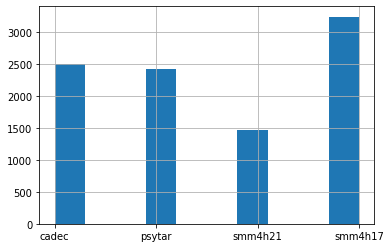

In [20]:
combined_data['corp'].hist()

# MRCONSO

In [ ]:
mrconso = pd.read_csv('../../data/external/mrconso_umls/MRCONSO_ENG.RRF', sep='|', header=None)

In [ ]:
mrconso = mrconso.rename(columns={
    0: "CUI", 
    1: 'LAT',
    2: 'TS',
    3: "LUI",
    4: "STT",
    5: "SUI",
    6: "ISPREF",
    7: "AUI",
    8: "SAUI",
    9: "SCUI",
    10: "SDUI",
    11: "SAB",
    12: "TTY",
    13: "CODE",
    14: "STR",
    15: "SRL",
    16: "SUPPRESS",
    17: "CVF"
})[
    ["CUI", "TS", "SAB", "TTY", "CODE", "STR"]
]

In [ ]:
mdr_codes = mrconso[mrconso['SAB']=="MDR"].groupby("CODE").agg(lambda x: x.unique())
snomed =    mrconso[mrconso['SAB']=="SNOMEDCT_US"]

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
mdr_codes = mdr_codes.reset_index(inplace=False)
mdr_codes['SNMS'] = mdr_codes['CUI'].progress_apply(lambda cui: snomed[snomed['CUI']==cui]['STR'].to_list())

In [ ]:
mdr_codes

In [ ]:
mdr_codes.to_csv('../../data/interim/meddra_codes_terms_synonims.csv', index=False)

In [ ]:
df

In [ ]:
df2[df2['code']==10013767]

In [ ]:
df[df['code']==10013767]

In [ ]:
df.loc[0, 'SNMS']

In [ ]:
df2.loc[0, 'SNMS']